
# Introduction and Setup

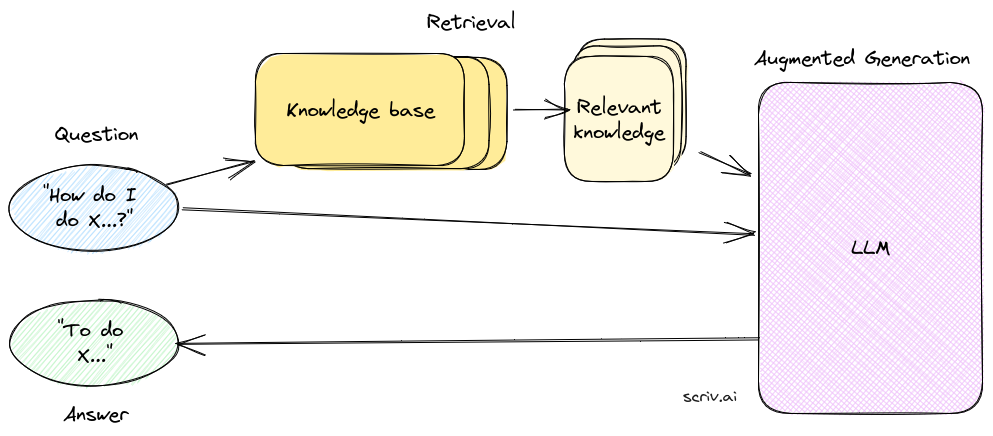


**Retrieval Augmented Generation (RAG)** is a process used to create Q&A bots. It starts with a user’s question and searches for the most relevant content from a knowledge base that might answer it. This is the retrieval step. The retrieved content is then sent, along with the user’s question, to a large language model (LLM) which reads the provided information and answers the question. This is the augmented generation step

# Installation & setup

## Python Modules

In [ ]:
!pip install langchain tiktoken openai chromadb faiss-cpu unstructured docx2txt pypdf langchain[docarray]

## OpenAI key

In [4]:
import os

# Set your OpenAI API key as an environment variable
os.environ["OPENAI_API_KEY"] = ""

# Experiment 1: Basic Usage of Langchain Module


## Get text from docx / website and put to vector store

In [ ]:
# https://scriv.ai/guides/retrieval-augmented-generation-overview/
from langchain.indexes import VectorstoreIndexCreator
from langchain.document_loaders import WebBaseLoader, Docx2txtLoader

# docx_loader = Docx2txtLoader("your.docx")
web_loader = WebBaseLoader("https://sme.sk")
index = VectorstoreIndexCreator().from_loaders([web_loader])
index.query("co je nove vo svete ?")


## Using agents - Interpret tabular data

In [6]:
from langchain.agents import create_pandas_dataframe_agent
from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType

from langchain.llms import OpenAI
import pandas as pd

import yfinance as yf

In [7]:
# get data of GSPC ticker (SP500 index) of period 1y
sp500 = yf.Ticker("^GSPC")
df = sp500.history(period="1y")

In [ ]:
df

### Temperature in ChatOpenAI
It is always a number between 0 and 1.
A temperature of 0 means the responses will be very straightforward, almost deterministic (meaning you almost always get the same response to a given prompt)
A temperature of 1 means the responses can vary wildly.

In [ ]:
agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-4"),
    df,
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    handle_parsing_errors=True
)

In [ ]:
agent.run("Create a matplotlib plot of the close price per date. Date is the index column. Data are close price of GSPC ticker.")

## Task 1: Plot 2 tickers on the same diagram

In [ ]:
sp500 = yf.Ticker("^GSPC")
tsla = yf.Ticker("TSLA")

df = sp500.history(period="1y")
df2 = tsla.history(period="1y")

agent = create_pandas_dataframe_agent(
    ChatOpenAI(temperature=0, model="gpt-4"),
    [df, df2],
    verbose=True,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    handle_parsing_errors=True
)

agent.run("Plot close prices of both data on the matplotlib plot. The data are stock market close prices, first one is sp500, second one is tesla. Put it to the label")

# Experiment 2: Token Size Analysis

Checkout https://platform.openai.com/tokenizer for visual difference between tokens and words. Try slovak and english words. You will see 2 time more tokens used when using slovak.

Tokens are fragments of words that the API disassembles input into. They may not align perfectly with word boundaries and can include trailing spaces. Understanding tokens is crucial for managing API costs, especially for languages other than English. The token limit is 4097 tokens shared between the prompt and completion, requiring creative strategies like text condensation or segmentation to work within this constraint. We'll also demonstrate how to count tokens using Tiktoken, a fast BPE tokenizer for OpenAI models, in Python.



| Model            | Context/Type  | Input Cost (per 1K tokens) | Output Cost (per 1K tokens) |
|------------------|---------------|----------------------------|----------------------------|
| gpt-4| 8K context | $0.03 | $0.06 |
| gpt-4-32k| 32K context | $0.06 | $0.12|
| gpt-3.5-turbo| 4K context    | $0.0015 | $0.002|
| | 16K context   | $0.003 | $0.004|
| Embedding Models| Ada v2 | $0.0001| |

### Task 2: Find out price for your input

In [12]:
def get_price(model, tokens):
  # TODO: finish code, so it will return price of your tokens based on the model
  if model == "gpt-4":
    return tokens/1000*0.03
  if model == "gpt-4-32k":
    return tokens/1000*0.06
  if model == "gpt-3.5-turbo":
    return tokens/1000*0.0015

def tokens_for_model(model, text):
  encoding = tiktoken.encoding_for_model(model)
  print(encoding.name)
  token_count = len(encoding.encode(text))
  return token_count


In [ ]:
import tiktoken

texts = [
    ("sk", "Slovenský jazyk je krásny a bohatý. Ľudia v Slovensku sa radi stretávajú s priateľmi a rodinou, aby si užili dobrej spoločnosti. Príroda v tejto krajine je ohromujúca, s vysokými horami, jazerami a zelenými lesmi. Slovensko je tiež známe svojou bohatou kultúrnou dedičinou a tradičnými slávnosťami. Ľudia tu majú radi dobré jedlo, ako halušky a bryndzové pirohy, a nezabúdajú na dôležitosť hudby a tancu. Celkovo je Slovensko úžasným miestom, ktoré ponúka kombináciu prírodného krásna a kultúrneho bohatstva."),
    ("en", "The Slovak language is beautiful and rich. People in Slovakia enjoy gathering with friends and family to savor good company. The nature in this country is stunning, with high mountains, lakes, and green forests. Slovakia is also known for its rich cultural heritage and traditional festivals. People here love good food, such as dumplings and bryndza pierogies, and they don't forget the importance of music and dance. Overall, Slovakia is an amazing place that offers a combination of natural beauty and cultural wealth.")
]
for model in ["gpt-4"]:
    for lang, text in texts:
      token_count = tokens_for_model(model, text)
      print(f"For model {model}: The {lang} text contains {token_count} tokens. Price would be ${get_price(model, token_count)}.")

# Experiment 3: Handling Long Texts with ChatGPT for Q&A bot without vector store
- https://github.com/gkamradt/langchain-tutorials/blob/main/chains/Chain%20Types.ipynb
- https://www.youtube.com/watch?v=f9_BWhCI4Zo


## Load docs

In [14]:
from langchain.document_loaders import UnstructuredFileLoader, WebBaseLoader
from langchain.chains.summarize import load_summarize_chain
from langchain.chains.question_answering import load_qa_chain

llm = ChatOpenAI(temperature=0)

In [15]:
# See: https://python.langchain.com/docs/modules/data_connection/document_loaders/
lg_loader = WebBaseLoader("https://www.gutenberg.org/files/27045/27045-0.txt")

lg_doc = lg_loader.load()

def doc_summary(docs):
    print (f'You have {len(docs)} document(s)')
    model = "gpt-4"
    num_words = sum([len(doc.page_content.split(' ')) for doc in docs])
    token_count = tokens_for_model(model," ".join([doc.page_content for doc in docs]))
    print (f'You have roughly {num_words} words in your docs')
    print (f'You have {token_count} tokens in your docs')
    print (f'You pay $ {get_price(model, token_count)}')
    print (f'Preview: \n{docs[0].page_content.split(". ")[0]}')

In [ ]:
doc_summary(lg_doc)

## Map Rerank

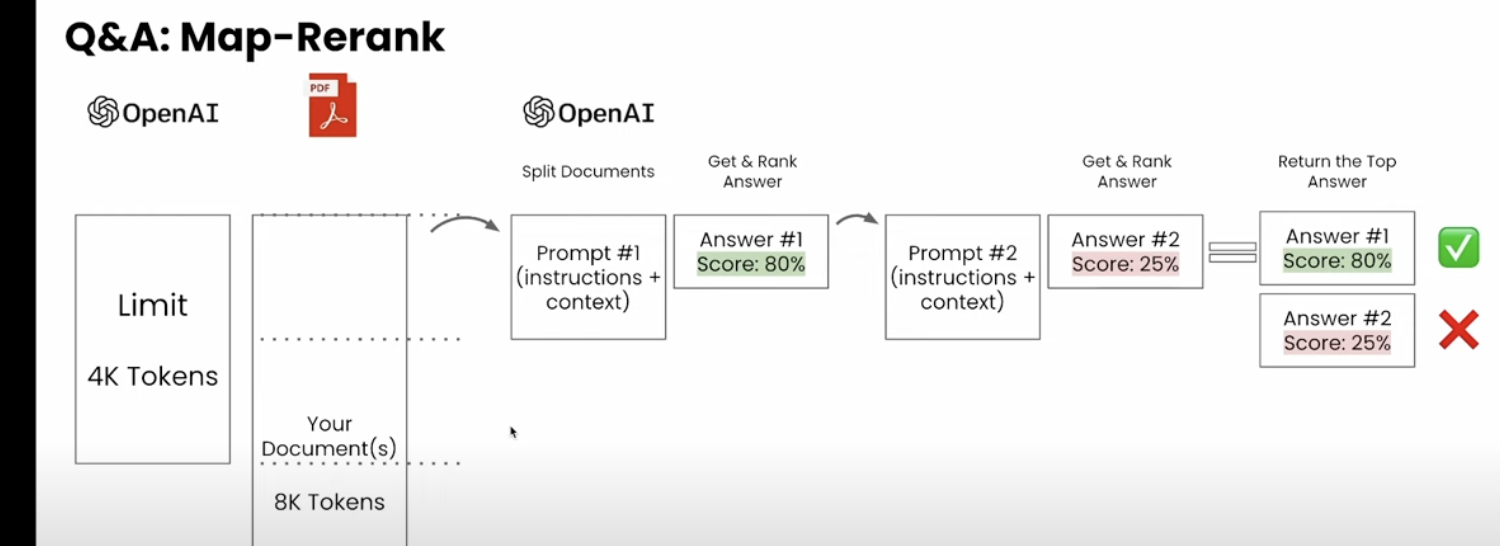


**Pros**

Better for single answer question

**Cons**

Cannot combine information between documents

### Split data to chunks

In [17]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 400,
    chunk_overlap = 0
)
lg_docs = text_splitter.split_documents(lg_doc)
doc_summary(lg_docs)

### QA chain with map_rerank

In [ ]:
chain = load_qa_chain(llm, chain_type="map_rerank", return_intermediate_steps=True)
query = "Who wrote Project Gutenberg ?"

result = chain({"input_documents": lg_docs[:5], "question": query}, return_only_outputs=True)
result

# Vector stores
https://www.researchgate.net/figure/KNN-with-two-dimensional-feature-space-and-two-classes-When-K-is-set-to-three-then-the_fig2_323784695

***Embeddings***

Embeddings are numerical representations of text, code, or other data. They are created by training a machine learning model on a large dataset of examples. The model learns to map each piece of data to a vector of numbers, which captures the meaning and context of the data.

Embeddings are often used in natural language processing (NLP) tasks, such as machine translation, text summarization, and question answering. They can also be used in other domains, such as computer vision and fraud detection.

***Vector stores***

Vector stores are specialized databases for storing and searching vector embeddings. They are designed to be efficient at finding the most similar vectors to a given query vector.

Vector stores are often used in applications that need to perform semantic search. For example, a vector store could be used to power a search engine that returns results based on the meaning of the query, rather than just the keywords.

***K-nearest neighbors (KNN)***

KNN is a machine learning algorithm that can be used for classification, regression, and anomaly detection. It works by finding the K most similar vectors to a given query vector.

KNN can be used in conjunction with vector stores to improve the performance of semantic search applications. For example, **a vector store could be used to find the K most similar vectors to a query vector, and then KNN could be used to classify the query vector or predict its value.**

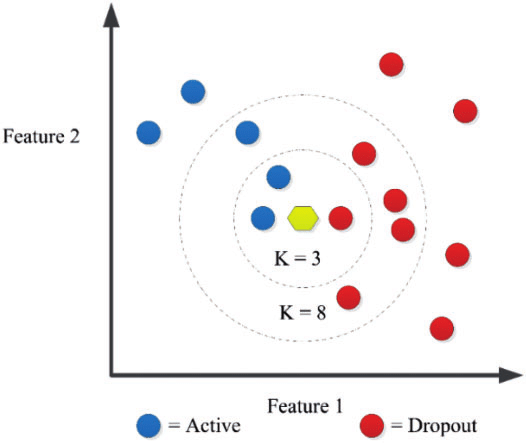

## Experiment 4: In memory vector store

In [28]:
from operator import itemgetter

from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
from langchain.vectorstores import FAISS

In [32]:
vectorstore = FAISS.from_texts(["V roku 1924 vznikla Bratislava, Vysoke Tatry a auta.", "Nizke Tatry neexistuju."], embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever()

model_runnable = ChatOpenAI(temperature=0)
template = """Answer the question based only on the following context:
{context}

Question: {question}

Answer in the following language: {language}
"""
prompt = ChatPromptTemplate.from_template(template)

chain = {
    "context": itemgetter("question") | retriever,
    "question": itemgetter("question"),
    "language": itemgetter("language")
} | prompt | model_runnable | StrOutputParser()



In [ ]:
chain.invoke({"question": "Kedy vznikli Vysoke Tatry ?", "language": "slovak"})

In [ ]:
chain.invoke({"question": "Porovnaj vysoke a nizke tatry", "language": "slovak"})

# Chatbot Sample

## Load and prepare chatbot

In [40]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import PyPDFLoader
from langchain.indexes import VectorstoreIndexCreator
from langchain.vectorstores import DocArrayInMemorySearch


### Task 3: Create chatbot

In [43]:
loader = PyPDFLoader("https://zmaturuj.zones.sk/materialy/ucebne-poznamky/literatura/poznamky-literatura-1-rocnik.pdf")
data = loader.load()

# DocArrayInMemorySearch is a document index provided by Docarray that stores documents in memory.
# It is a great starting point for small datasets, where you may not want to launch a database server.

index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch
).from_loaders([loader])

# add llm and retriever
qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(temperature = 0.0),
    chain_type="stuff",
    retriever=index.vectorstore.as_retriever(),
    verbose=True,
)

## Chatbot loop

In [ ]:
while (question := input("Question: ")):
  print(f'Answer: {qa.run(question)}')

# Experiment 5: Evaluation
https://github.com/Ryota-Kawamura/LangChain-for-LLM-Application-Development/blob/main/L5-Evaluation.ipynb



Evaluating responses from chatbots serves multiple pivotal purposes within the sphere of development and deployment of conversational agents. Here's a breakdown of the rationale and the areas of focus:

**Accuracy**

The primary goal is to ensure that the information provided by the chatbot is correct and accurate. An inaccurate chatbot can misinform users and potentially cause harm or confusion.

**Relevance**

Responses should be relevant to the queries posed. Irrelevant responses can frustrate users and deter them from using the chatbot further.

**Consistency**

Consistent responses build trust with users. Inconsistencies can lead to confusion and a lack of trust in the system.
**Completeness**

Responses should be complete and provide a satisfactory answer to the user’s question. Incomplete answers can leave users feeling frustrated and may require them to seek information elsewhere.

**Conciseness**

While being complete, responses should also be concise and to the point. Overly verbose responses can be seen as inefficient and frustrating.

**Understandability**

The language used should be clear, easy to understand, and appropriate for the target audience.

**Interactivity**

Evaluating how well the chatbot handles a conversational flow, including follow-up questions and contextual understanding, is crucial for a good user experience.

**Adherence to Ethical Guidelines**

Ensuring the chatbot operates within established ethical guidelines, including respecting user privacy and providing unbiased, respectful responses.

**Customizability and Scalability**

Evaluation can help in understanding how easily the chatbot can be customized or scaled to handle a wider range of queries or a larger user base.

**Performance Metrics**

Collecting performance metrics through evaluation helps in understanding the chatbot's capabilities and areas of improvement, which is crucial for iterative development.

**User Satisfaction**

Evaluating user satisfaction through feedback and other metrics is essential for understanding the real-world impact and usability of the chatbot.

**Debugging and Improvement**

Evaluations can uncover bugs or shortcomings in the chatbot’s design, which can then be addressed in subsequent development cycles.

**Compliance and Documentation**

Ensuring that the chatbot complies with industry standards, legal requirements, and is well-documented for transparency and accountability.

**Benchmarking**

Comparing the performance and capabilities of a chatbot against industry benchmarks or competitors can provide valuable insights and drive improvements.
Through a well-structured evaluation process, developers, stakeholders, and users can gain a better understanding of the chatbot's strengths, weaknesses, and areas for improvement, which in turn can guide further development and optimization towards creating a more effective and user-friendly conversational agent.

In [44]:
from langchain.evaluation.qa import QAEvalChain

In [45]:
test_dataset = [
    {
        "query": "Ake je ohranicenie rokov pre Staršia slovenská literatúra ?",
        "answer": "od roku 800 do roku 1780"
    },
    {
        "query": "Aka basen sa zachovala od Sapfo ?",
        "answer": "Modlitba k Herkulovi"
    }
]

In [ ]:
predictions = qa.apply(test_dataset)

In [47]:
llm = ChatOpenAI(temperature=0)
eval_chain = QAEvalChain.from_llm(llm)

In [ ]:
graded_outputs = eval_chain.evaluate(test_dataset, predictions)

for i, eg in enumerate(test_dataset):
    print(f"Example {i}:")
    print("Question: " + predictions[i]['query'])
    print("Real Answer: " + predictions[i]['answer'])
    print("Predicted Answer: " + predictions[i]['result'])
    print("Predicted Grade: " + graded_outputs[i]['results'])
    print()

# Further steps
- checkout to our presentation on Openslava 2023 in Bratislava, 19th october at 13:50 https://www.openslava.sk/2023/#/program/fa216088-7f78-4974-bcda-4f750435acb4
- go through source links to github/youtube/... in each experiment and try to understand the code
- if you want to have openai as desktop app or command line, accessing to your local data check this out. https://openinterpreter.com/
- do not hesitate to contact me jozef.resetar@ableneo.com